This is a toy 1-hidden_layers-NN (1iu-3hu-1ou) with the purpose of learning to implement forward and back propagation. It will have a dataset of 1000 examples $(x,y)$ of floating numbers and the goal is to approximate the function $y = 2x$

In [413]:
# we use numpy for maths, pandas for (little) data manipulation and pyplot for plotting graphics
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv('.\dataset y_2x\dataset_f_x_2x.csv') # this is our dataset, made of 1000 examples
data.head() # will show the first 5 rows of the csv

,x,y
0,67.232,134.464
1,-9.597,-19.194
2,39.954,79.908
3,31.415,62.830
4,-43.281,-86.562


In [414]:
# we don't really want to use pandas framework to deal with data. We can use instead numpy for better matrix ops
data = np.array(data) # now we have our data in an array -- data.shape = (1000,2)
#m, n = data.shape
np.random.shuffle(data) # shuffling is a good habit
data

array([[  89.614,  179.228],
       [ -89.329, -178.658],
       [  81.862,  163.724],
       ...,
       [ -79.963, -159.926],
       [  46.598,   93.196],
       [  20.864,   41.728]])

In [415]:
# now we have the dataset (shuffled): let's split it in TR set and VAL set
tr_set = data[0:750].T # we transpose the tensor in order to have the column(s) representing the examples
# splitting inputs and outputs: note that the splitting must be done according the shape of our dataset
# nothe that in this case, we have only 1 feature x, so the input will be a monodimensional array
X_tr = tr_set[0] # X is the input
Y_tr = tr_set[1] # Y is the target

test_set = data[750:].T
X_test = test_set[0]
Y_test = test_set[1]

# the next operation forces the arrays to be matrixes of dimension (n,1) because with numpy is better to operate with only matrixes
# to avoid errors during computations
X_tr,Y_tr,X_test,Y_test = map(lambda arr: np.expand_dims(arr, axis=1), (X_tr,Y_tr,X_test,Y_test))

In [416]:
# here you can visualize the dimensions
Y_tr.shape

(750, 1)

In [417]:
# now we have to inizialize our parameters: w and b (is good to inizialize b with zeros?)
def init_params(n_units): #maybe i can implement fan-in inizializations of w's, so i need to put fan_in as parameter
    W1 = np.random.uniform(-0.7,0.7,(n_units,1)) # our W matrix matches the number of units of the layer and the number of inputs of the previous layer
    b1 = np.zeros((n_units,1))
    W2 = np.random.uniform(-0.7,0.7,(1,n_units))
    b2 = 0
    return W1, b1, W2, b2

In [418]:
# Let's define our pieces for Gradient Descent Algorithm
# activation function
def ReLU(Z):
    return np.maximum(0,Z) # is element wise, so I can use vectors or matrixes as input

def deriv_ReLU(Z):
    return Z > 0

# define the forward propagaion
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X.T) + b1 #Z equals to (w_tu*x_u+b_u)
    A1 = ReLU(Z1) #Activation Function
    Z2 = W2.dot(A1) + b2
    A2 = Z2 # this is my prediction in input x
    return Z1, A1, Z2, A2

def MSE(A,Y):
    return np.mean(np.square(A - Y.T))

def MSE_derivative(A, Y):
    return (2 / 750) * (A - Y.T)


# define the back propagation, with d we intend the partial derivative
def back_prop(Z1, A1, Z2, A2, W2, X, Y):
    m = Y.size
    dZ2 = MSE_derivative(A2, Y) # here I use my Loss function
    dW2 = 1/m * dZ2.dot(A1.T)
    db2 = 1/m * np.sum(dZ2, axis=1, keepdims = True)
    dZ1 = W2.T.dot(dZ2) * deriv_ReLU(Z1)
    dW1 =  1/m * dZ1.dot(X)
    db1 = 1/m * np.sum(dZ1, axis=1, keepdims = True)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, eta):
    W1 = W1 - eta * dW1
    b1 = b1 - eta * db1
    W2 = W2 - eta * dW2
    b2 = b2 - eta * db2
    return W1, b1, W2, b2

In [419]:
# Let's combine the pieces
def gradient_descent(X, Y, epochs, eta, n_units):
    W1, b1, W2, b2 = init_params(n_units)
    loss_data = []
    for i in range(epochs):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = back_prop(Z1, A1, Z2, A2, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, eta)

        loss = MSE(A2, Y)
        loss_data.append({'epoch': i, 'loss': loss})
    loss_df = pd.DataFrame(loss_data)
    loss_df.to_csv('loss_values.csv', index=False)

    return W1, b1, W2, b2

In [420]:
# training
W1, b1, W2, b2 = gradient_descent(X_tr, Y_tr, 50, 0.1, 3)

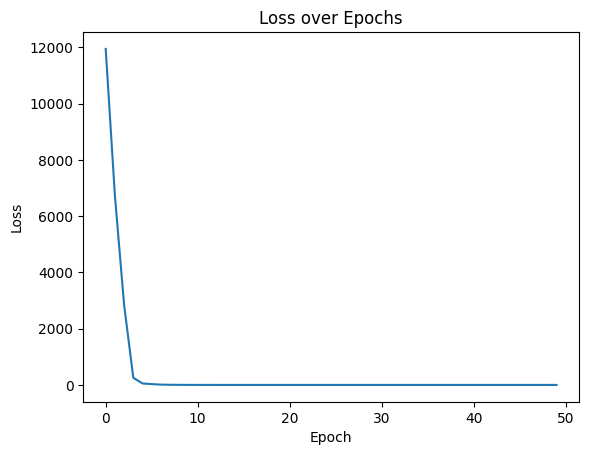

In [421]:
# now I want to plot my Loss
loss_df = pd.read_csv('loss_values.csv')

plt.plot(loss_df['epoch'], loss_df['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.show()

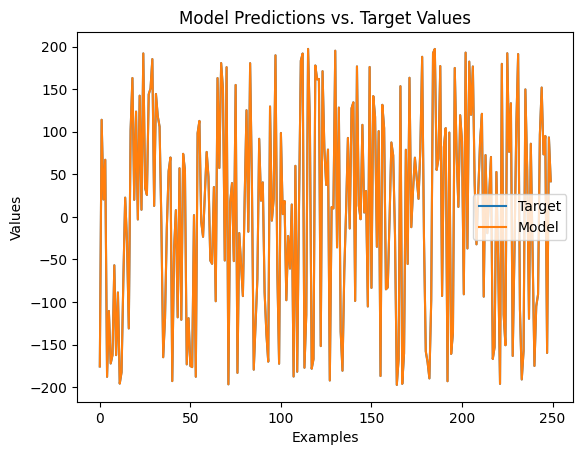

In [ ]:
# testing the model on test set
def testing(W1, b1, W2, b2, X, Y): #essentially, a cicle of Forward prop
    Z1 = W1.dot(X.T) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = Z2
    
    #plotting the graphic of targets vs predicions
    plt.plot(Y.flatten(), label="Target")
    plt.plot(A2.flatten(), label="Model")
    plt.xlabel("Examples")
    plt.ylabel("Values")
    plt.title("Model Predictions vs. Target Values")
    plt.legend()
    plt.show()

    # saving comparison into a csv
    assert Y_test.shape == A2.T.shape, "Y_test and A2 must have same dimension"
    data = {
        'Target': Y_test.flatten(),
        'Prediction': A2.flatten()
    }

    df = pd.DataFrame(data)
    df.to_csv('target_vs_prediction.csv', index=False)

testing(W1, b1, W2, b2, X_test, Y_test)